In [1]:
# Data Handling
import pandas as pd
import numpy as np
from datetime import datetime
from dateutil.relativedelta import relativedelta

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objs as go
import plotly.subplots as sp
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)

# Financial Data Analysis
import yfinance as yf
import ta
import quantstats as qs

# Machine Learning 
from sklearn.metrics import confusion_matrix, roc_auc_score, auc, roc_curve

# Classification ML algorithms
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
# from catboost import CatBoostClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier

# Feature Selection
from sklearn.feature_selection import SelectKBest, f_classif

# Oversampling minority class for imbalanced datasets
from imblearn.over_sampling import SMOTE

# Feature Importance
from sklearn.inspection import permutation_importance

# Hiding warnings 
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Loading Cocoa weekly historic data 
today = datetime.today()
start_date = today - relativedelta(years=20)

cocoa = yf.download('CC=F', start = start_date, end = today,
                    interval = '1wk') # 1-week timeframe

cocoa.head()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2004-07-05,1417.0,1417.0,1417.0,1417.0,1417.0,3
2004-07-12,1425.0,1545.0,1425.0,1528.0,1528.0,14422
2004-07-19,1545.0,1639.0,1530.0,1620.0,1620.0,36922
2004-07-26,1620.0,1672.0,1575.0,1645.0,1645.0,29725
2004-08-02,1685.0,1738.0,1595.0,1610.0,1610.0,37947


In [3]:
# Designing Candlestick chart
candlestick = go.Candlestick(x = cocoa.index,
                            open = cocoa['Open'],
                            high = cocoa['High'],
                            low = cocoa['Low'],
                            close = cocoa['Adj Close'],
                            increasing = dict(line=dict(color = 'skyblue')),
                            decreasing = dict(line=dict(color = 'darkblue')))

In [4]:
# Defining layout
layout = go.Layout(title = {'text': '<b>Cocoa Sep 24</b> <br><sup>(20 YRs Look Back)</sup>',
                           'x': 0.5,
                           'xanchor': 'center',
                           'yanchor': 'top',
                           'font': {
                               'size': 25
                           }},
                  yaxis = dict(title = 'Price (USD)'),
                  xaxis = dict(title = 'Date'),
                  template = 'ggplot2',
                  xaxis_rangeslider_visible = True,
                  yaxis_gridcolor = 'lightgray',
                  yaxis_tickfont = dict(color = 'black'),
                  xaxis_tickfont = dict(color = 'black'),
                  margin = dict(t = 80, l = 50, r = 50, b = 50),
                  height = 650, width = 1000,
                  plot_bgcolor = 'white')

fig = go.Figure(data = [candlestick], layout = layout)

In [5]:
fig.show()

In [6]:
# Splitting data into training & testing sets
train = cocoa[cocoa.index.year <= 2014] 
test = cocoa[cocoa.index.year >= 2015]

In [7]:
# Defining new features to improve the predictive power of the algorithms
def new_features(df):
    
    # Features related to price behavior
    df['high_low_ratio'] = df['High'] / df['Low']
    df['open_adjclose_ratio'] = df['Adj Close'] / df['Open']
    df['candle_to_wick_ratio'] = (df['Adj Close'] - df['Open']) / (df['High'] - df['Low'])
    upper_wick_size = df['High'] - df[['Open', 'Adj Close']].max(axis = 1)
    lower_wick_size = df[['Open', 'Adj Close']].min(axis = 1) - df['Low'] 
    df['upper_to_lower_wick_ratio'] = upper_wick_size /  lower_wick_size
    
    # Laggings
    df['lag1'] = df['Adj Close'].shift(1)
    df['lag2'] = df['Adj Close'].shift(2)
    df['lag3'] = df['Adj Close'].shift(3)
    df['lag4'] = df['Adj Close'].shift(4)
    df['lag5'] = df['Adj Close'].shift(5)
    
    # Laggings ratio
    df['close_to_lag1_ratio'] = df['Adj Close'] / df['lag1']
    df['close_to_lag2_ratio'] = df['Adj Close'] / df['lag2']
    df['close_to_lag3_ratio'] = df['Adj Close'] / df['lag3']
    df['close_to_lag4_ratio'] = df['Adj Close'] / df['lag4']
    df['close_to_lag5_ratio'] = df['Adj Close'] / df['lag5']
    
    df['ema2'] = ta.trend.ema_indicator(df['Adj Close'], window = 2)
    
    # Volatility features
    df['9_days_volatility'] = df['Adj Close'].pct_change().rolling(window = 9).std()
    df['20_days_volatility'] = df['Adj Close'].pct_change().rolling(window = 20).std()
    df['9_to_20_day_vol_ratio'] = df['9_days_volatility'] / df['20_days_volatility']
    
    # Technical indicators
    df['rsi'] = ta.momentum.RSIIndicator(df['Adj Close']).rsi()
    df['rsi_overbought'] = (df['rsi'] >= 70).astype(int)
    df['rsi_oversold'] = (df['rsi'] <= 30).astype(int)
    df['cci'] = ta.trend.cci(df['High'], df['Low'], df['Adj Close'], window=10, constant=0.015)
    df['obv'] = ta.volume.OnBalanceVolumeIndicator(close=df['Adj Close'], volume=df['Volume']).on_balance_volume()
    df['obv_divergence_5_days'] = df['obv'].diff().rolling(10).sum() - df['Adj Close'].diff().rolling(5).sum()
    df['obv_divergence_10_days'] = df['obv'].diff().rolling(20).sum() - df['Adj Close'].diff().rolling(10).sum()
    df['ADX'] = ta.trend.ADXIndicator(df['High'], df['Low'], df['Adj Close'], window = 10).adx()
    df['ADI'] = ta.volume.AccDistIndexIndicator(df['High'], df['Low'], df['Adj Close'], df['Volume']).acc_dist_index()
    
    # Weekly returns
    df['returns'] = np.round((df['Adj Close'].pct_change()) * 100, 2)
    
    # Ratio between the closing price and the 8-period exponential moving average
    # When < 1 --> prices are being traded below the moving average --> a possible downtrend
    df['close_to_ema2_ratio'] = df['Adj Close'] / df['ema2']
    
    # Replacing infinite values by zeros
    df = df.replace([np.inf, -np.inf], 0)
    
    # Removing NaN values
    df = df.dropna()
    return df

In [8]:
# Applyig new_features function to both datasets
train = new_features(train)
test = new_features(test)

In [9]:
train.tail() # Displaying results

,Open,High,Low,Close,Adj Close,Volume,high_low_ratio,open_adjclose_ratio,candle_to_wick_ratio,upper_to_lower_wick_ratio,...,rsi_overbought,rsi_oversold,cci,obv,obv_divergence_5_days,obv_divergence_10_days,ADX,ADI,returns,close_to_ema2_ratio
Date,,,,,,,,,,,,,,,,,,,,,
2014-12-01,2938.0,2938.0,2889.0,2929.0,2929.0,20,1.016961,0.996937,-0.183673,0.000000,...,0,0,-40.509692,658501,-378845.0,-4050.0,24.651984,-309022.541047,1.70,1.006085
2014-12-08,2933.0,2984.0,2899.0,2891.0,2891.0,67,1.029320,0.985680,-0.494118,-6.375000,...,0,0,-27.967776,658434,-294569.0,-109468.0,23.676782,-309102.152811,-1.30,0.997667
2014-12-15,2910.0,2990.0,2885.0,2980.0,2980.0,59154,1.036395,1.024055,0.666667,0.400000,...,0,0,7.142857,717588,-296845.0,-119445.0,23.052090,-261215.581383,3.08,1.009284
2014-12-22,2995.0,2997.0,2935.0,2941.0,2941.0,21499,1.021124,0.981970,-0.870968,0.333333,...,0,0,41.486811,696089,-251685.0,-222268.0,22.299073,-278553.484608,-1.31,0.998688
2014-12-29,2962.0,2988.0,2896.0,2927.0,2927.0,40090,1.031768,0.988184,-0.380435,0.838710,...,0,0,49.194232,655999,-237353.0,-220816.0,22.393388,-291626.310695,-0.48,0.997970


In [10]:
# Setting Candlestick chart
candlestick = go.Candlestick(x = train.index,
                            open = train['Open'],
                            high = train['High'],
                            low = train['Low'],
                            close = train['Adj Close'],
                            increasing = dict(line=dict(color = 'skyblue')),
                            decreasing = dict(line=dict(color = 'darkblue')),
                            name = 'Candles')

# Setting moving average on plot
ema2 = go.Scatter(x = train.index,
                 y = train['ema2'],
                 mode = 'lines',
                 line=dict(color='orange', width = 2),
                 name = 'EMA')

# Defining the overall layout
layout = go.Layout(title = {'text': '<b>Cocoa Sep 24</b> <br><sup>(Training Period)</sup>',
                           'x': 0.5,
                           'xanchor': 'center',
                           'yanchor': 'top',
                           'font': {
                               'size': 25
                           }},
                  yaxis = dict(title = 'Price (USD)'),
                  xaxis = dict(title = 'Date'),
                  template = 'ggplot2',
                  xaxis_rangeslider_visible = True,
                  yaxis_gridcolor = 'lightgray',
                  yaxis_tickfont = dict(color = 'black'),
                  xaxis_tickfont = dict(color = 'black'),
                  margin = dict(t = 80, l = 50, r = 50, b = 50),
                  height = 650, width = 1000,
                  plot_bgcolor = 'white')

fig = go.Figure(data = [candlestick, ema2], layout = layout)

fig.show()

In [11]:
# Boxplot 
fig = px.box(train, x = 'close_to_ema2_ratio', points = 'all')

# Layout
fig.update_traces(boxpoints = 'all', marker_color = 'lightsteelblue')
fig.update_layout(height = 350, width = 1000,
                 template = 'plotly_white',
                  title = {'text': '<b>Close-to-Exponential Moving Average 2 Ratio - Boxplot</b>',
                  'x': 0.5,
                  'xanchor': 'center',
                  'yanchor': 'top',
                  'font': {
                      'size': 25
                  }},
                  margin = dict(t=100)
                 )

fig.show()

In [12]:
# Obtaining the mean of returns by range in the 'close_to_ema2_ratio' attribute
octiles = np.arange(0, 1.05, 0.05)
octile_intervals = np.quantile(train['close_to_ema2_ratio'],
                              octiles)
ranges = pd.cut(train['close_to_ema2_ratio'], octile_intervals)
data = pd.DataFrame({'ranges': ranges,
                    'returns': train['returns']})
mean_values = data.groupby('ranges')['returns'].mean()

crosstab = pd.crosstab(index = mean_values.index,
                      columns = 'mean_returns',
                      values = mean_values.values,
                      aggfunc = 'mean')
crosstab

col_0,mean_returns
row_0,
"(0.928, 0.975]",-8.014615
"(0.975, 0.981]",-5.748077
"(0.981, 0.985]",-3.581154
"(0.985, 0.988]",-3.501852
"(0.988, 0.991]",-2.760769
"(0.991, 0.994]",-1.948462
"(0.994, 0.996]",-1.628077
"(0.996, 0.998]",-0.945926
"(0.998, 1.0]",-0.100769


In [13]:
# Creating target variable
def target(df):
    df['target'] = np.where(df['close_to_ema2_ratio'] <= 1.0, 0, 1)
    df['target'] = df['target'].shift(-1) 
    # shift the target variable one sample backwards to capture the characteristics of the current week that culminated in a value of 1 or 0 in the following week
    df = df.dropna()
    return df

In [14]:
# Applying function
train = target(train)
test = target(test)

In [15]:
train.head() # Displaying results

,Open,High,Low,Close,Adj Close,Volume,high_low_ratio,open_adjclose_ratio,candle_to_wick_ratio,upper_to_lower_wick_ratio,...,rsi_oversold,cci,obv,obv_divergence_5_days,obv_divergence_10_days,ADX,ADI,returns,close_to_ema2_ratio,target
Date,,,,,,,,,,,,,,,,,,,,,
2004-11-22,1590.0,1610.0,1562.0,1610.0,1610.0,58,1.030730,1.012579,0.416667,0.000000,...,0,50.753411,190584,82452.0,190432.0,34.953203,44500.022874,0.50,0.998030,1.0
2004-11-29,1605.0,1745.0,1575.0,1745.0,1745.0,262,1.107937,1.087227,0.823529,0.000000,...,0,94.547499,190846,104284.0,176134.0,36.418567,44762.022874,8.39,1.025831,0.0
2004-12-06,1758.0,1766.0,1648.0,1660.0,1660.0,28,1.071602,0.944255,-0.830508,0.666667,...,0,80.497795,190818,130439.0,139261.0,37.896028,44739.717789,-4.87,0.991823,0.0
2004-12-13,1640.0,1682.0,1596.0,1600.0,1600.0,13209,1.053885,0.975610,-0.465116,10.500000,...,0,26.487815,177609,141306.0,96362.0,38.020642,32759.461975,-3.61,0.984881,0.0
2004-12-20,1585.0,1601.0,1550.0,1552.0,1552.0,18608,1.032903,0.979180,-0.647059,8.000000,...,0,-33.287567,159001,104392.0,115771.0,37.121903,15610.912956,-3.00,0.984654,0.0


In [16]:
# Pie plot
fig = px.pie(train, names = 'target', hole = .5)

# Layout
fig.update_traces(marker=dict(colors=['red', 'blue']))

fig.update_layout(title = {'text':'<b>Distribution of Classes in the Target Variable</b>',
                           'x': 0.5,
                           'xanchor': 'center',
                           'yanchor': 'top',
                           'font': {
                               'size': 25
                           }},
                  margin=dict(t=100)
                 )
fig.show()

In [17]:
# Splitting data into Independent Features X and Target Variable y
X_train = train.drop('target', axis = 1)
y_train = train.target

X_test = test.drop('target', axis = 1)
y_test = test.target

In [18]:
# Applying oversampling using SMOTE
smote = SMOTE(random_state = 30) # balance the class distribution in your training data.

X_train_oversampled, y_train_oversampled = smote.fit_resample(X_train,y_train)

In [19]:
# Pie plot
fig = px.pie(y_train_oversampled, names = y_train_oversampled.values, hole = .5)
fig.update_traces(marker=dict(colors=['red', 'blue']))

# Layout
fig.update_layout(title = {'text':'<b>Distribution of Classes in the Target Variable</b><br><sup>(After Oversampling)</sup>',
                           'x': 0.5,
                           'xanchor': 'center',
                           'yanchor': 'top',
                           'font': {
                               'size': 25
                           }},
                  margin=dict(t=100)
                 )
fig.show()

In [20]:
# Selecting Features using SelectKBest
# Identify the most relevant features according to its k score
k_best = SelectKBest(score_func = f_classif,
                     k = len(X_train.columns))

# Fitting and transforming data
X_train_best = k_best.fit_transform(X_train, y_train)
X_test_best = k_best.transform(X_test)

feat_indices = k_best.get_support(indices = True)
feat_names = X_train.columns[feat_indices]

p_values = k_best.pvalues_

selected_features = []

for feature, pvalue in zip(feat_names, p_values):
    if pvalue < 0.01: # p-value < 1% as threshold
        selected_features.append(feature)
        
print("Selected Features: \n")
print(selected_features)

Selected Features: 

['open_adjclose_ratio', 'candle_to_wick_ratio', 'close_to_lag1_ratio', 'close_to_lag2_ratio', 'close_to_lag3_ratio', 'returns', 'close_to_ema2_ratio']


In [21]:
# Selecting only the best features
X_train_best = X_train[selected_features]
X_test_best = X_test[selected_features]

In [22]:
# Creating list of classifiers
classifiers = [
    LogisticRegression(random_state = 30),
    XGBClassifier(random_state = 30),
    LGBMClassifier(random_state = 30),
    # CatBoostClassifier(random_state = 30, verbose = False),
    AdaBoostClassifier(random_state = 30),
    RandomForestClassifier(random_state = 30),
    GradientBoostingClassifier(random_state = 30),
    MLPClassifier(random_state = 30)
]

# Iterating over classifiers and computing AUC (Area Under the ROC Curve score)
for clf in classifiers:
    clf.fit(X_train_best, y_train)
    preds = clf.predict_proba(X_test_best)[:,1]
    auc_score = roc_auc_score(y_test, preds)
    print(f'{type(clf).__name__}: AUC Score = {auc_score:.3f}')

LogisticRegression: AUC Score = 0.687
XGBClassifier: AUC Score = 0.580
[LightGBM] [Info] Number of positive: 283, number of negative: 242
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000294 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1227
[LightGBM] [Info] Number of data points in the train set: 525, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.539048 -> initscore=0.156509
[LightGBM] [Info] Start training from score 0.156509
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

In [23]:
# Building best model
model = LogisticRegression(random_state = 30)
model.fit(X_train_best, y_train)
y_pred = model.predict_proba(X_test_best)[:,1]

# Computing AUC score
fpr, tpr, thersholds = roc_curve(y_test, y_pred)
auc_score = auc(fpr, tpr)

# Plotting the AUC-ROC Plot
fig = go.Figure()

# Area Under the Curve
fig.add_trace(go.Scatter(x = fpr,
                        y = tpr,
                        mode = 'lines',
                        fill = 'tozeroy',
                        line=dict(color = 'cornflowerblue', width = 2),
                        name = f'AUC = {auc_score:.3f}'))

In [24]:
# Random Guess line
fig.add_trace(go.Scatter(x = [0,1],
                       y = [0,1],
                       mode = 'lines',
                       line=dict(color = 'indigo', width = 1.5, dash = 'longdashdot'),
                       name = 'Random Guess'))

# Layout
fig.update_layout(xaxis = dict(range=[0.0, 1.0]),
                 yaxis = dict(range=[0.0, 1.05]),
                 xaxis_title = 'False Positive Rate',
                 yaxis_title = 'True Positive Rate',
                 title = {
                     'text':'<b>Area Under the Curve - Logistic Regression Model</b>',
                     'x': 0.5,
                     'xanchor': 'center',
                     'yanchor': 'top',
                     'font': {
                         'size': 25
                     }
                 },
                 margin = dict(t = 180),
                 legend = dict(x=1, y=1, xanchor = 'right', yanchor = 'bottom'),
                 plot_bgcolor = 'white',
                 showlegend = True,
                 height = 650, width = 1000)
fig.show() # Displaying figure

In [25]:
result = permutation_importance(model, X_test_best, y_test, n_repeats=100, random_state=30) # Computing feature importance

# Computing mean scores and obtaining features' names
importances = result.importances_mean
feature_names = X_test_best.columns

# Sorting Features importances and names
indices = importances.argsort()[::1]
sorted_features = feature_names[indices]
sorted_importances = importances[indices]

# Plotting Feature Importance
fig = go.Figure()

fig.add_trace(go.Bar(x = sorted_importances,
                    y = sorted_features,
                    marker = dict(color = 'steelblue'),
                    orientation = 'h'))

fig.update_layout(title = {'text':'<b>Logistic Regression - Feature Importance</b>',
                          'x': 0.5,
                          'xanchor': 'center',
                          'yanchor': 'top',
                          'font': {
                              'size': 25
                          }},
                 margin = dict(t = 100),
                 xaxis_title = 'Importance',
                 yaxis_title = 'Features',
                 showlegend = False,
                 height = 750,
                 width = 1000,
                 plot_bgcolor = 'white')
fig.show()

In [26]:
y_pred # Displaying probabilities

array([0.48050855, 0.54913897, 0.50154175, 0.64554775, 0.52282167,
       0.53158547, 0.53144387, 0.54822623, 0.39001193, 0.52976737,
       0.44276157, 0.46491672, 0.55697998, 0.53254276, 0.52982233,
       0.6006316 , 0.60090571, 0.54426337, 0.36933405, 0.50394287,
       0.59351614, 0.53177398, 0.64669663, 0.52016476, 0.61866948,
       0.53924561, 0.54556829, 0.60095584, 0.5907586 , 0.45494183,
       0.51161609, 0.53618399, 0.31801656, 0.41519194, 0.50470497,
       0.41350265, 0.54539904, 0.60082223, 0.53531026, 0.55450938,
       0.6569816 , 0.53064043, 0.61048715, 0.37837849, 0.44601048,
       0.51013285, 0.58941725, 0.74894274, 0.58572989, 0.48028216,
       0.50282337, 0.607233  , 0.56372785, 0.60981332, 0.49420875,
       0.52858055, 0.51652287, 0.63061769, 0.48221899, 0.33827612,
       0.50056238, 0.73628852, 0.5120962 , 0.60349139, 0.48211551,
       0.47843436, 0.40362952, 0.55777826, 0.59012399, 0.43411867,
       0.54585695, 0.46653051, 0.51853586, 0.54397683, 0.33347

In [27]:
octiles = np.arange(0, 1.125, 0.125)
intervals = np.quantile(y_pred, octiles)
classes = pd.cut(y_pred, intervals)
table = pd.crosstab(classes, y_test)
table

target,0.0,1.0
row_0,,
"(0.0102, 0.413]",43,14
"(0.413, 0.477]",38,20
"(0.477, 0.511]",34,24
"(0.511, 0.538]",20,38
"(0.538, 0.565]",22,36
"(0.565, 0.604]",24,34
"(0.604, 0.674]",17,41
"(0.674, 0.99]",13,45


In [28]:
# Creating sign
sign = np.where((y_pred <= 0.511), -1, 1)
sign # Visualizing results

array([-1,  1, -1,  1,  1,  1,  1,  1, -1,  1, -1, -1,  1,  1,  1,  1,  1,
        1, -1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1, -1, -1,
       -1, -1,  1,  1,  1,  1,  1,  1,  1, -1, -1, -1,  1,  1,  1, -1, -1,
        1,  1,  1, -1,  1,  1,  1, -1, -1, -1,  1,  1,  1, -1, -1, -1,  1,
        1, -1,  1, -1,  1,  1, -1, -1,  1,  1, -1, -1,  1,  1, -1,  1, -1,
       -1, -1, -1, -1,  1,  1, -1,  1,  1,  1, -1, -1, -1,  1, -1,  1,  1,
       -1,  1,  1, -1, -1,  1,  1,  1,  1, -1,  1, -1,  1,  1, -1,  1, -1,
        1,  1,  1,  1, -1, -1,  1, -1, -1, -1, -1,  1, -1,  1,  1,  1,  1,
        1,  1, -1,  1,  1,  1,  1,  1, -1, -1,  1,  1,  1, -1,  1, -1, -1,
       -1, -1,  1, -1, -1,  1, -1, -1, -1, -1,  1,  1,  1, -1, -1, -1, -1,
       -1, -1,  1,  1,  1,  1, -1, -1, -1,  1,  1,  1,  1,  1, -1,  1, -1,
       -1, -1,  1,  1,  1, -1, -1,  1, -1,  1,  1,  1, -1, -1,  1, -1, -1,
        1, -1,  1,  1,  1,  1,  1, -1, -1, -1, -1, -1,  1,  1,  1,  1,  1,
        1,  1, -1, -1,  1

In [29]:
X_test['sign'] = sign # Model's predictions for next week
X_test['position'] = X_test['sign'].shift(1) # Current position
X_test['model_returns'] = X_test['position'] * X_test['returns'] # Obtaining return according to model's predictions
X_test # Displaying results on the dataframe

,Open,High,Low,Close,Adj Close,Volume,high_low_ratio,open_adjclose_ratio,candle_to_wick_ratio,upper_to_lower_wick_ratio,...,obv,obv_divergence_5_days,obv_divergence_10_days,ADX,ADI,returns,close_to_ema2_ratio,sign,position,model_returns
Date,,,,,,,,,,,,,,,,,,,,,
2015-05-25,3124.0,3155.0,3081.0,3085.0,3085.0,66720,1.024018,0.987516,-0.527027,7.750000,...,97801,186352.0,28086.0,18.497899,-27036.901330,-2.16,0.996117,-1,NaN,NaN
2015-06-01,3090.0,3143.0,3050.0,3116.0,3116.0,103150,1.030492,1.008414,0.279570,0.675000,...,200951,370609.0,169885.0,18.358374,16219.550283,1.00,1.002034,1,-1.0,-1.00
2015-06-08,3093.0,3157.0,3085.0,3140.0,3140.0,82099,1.023339,1.015196,0.652778,2.125000,...,283050,360948.0,336937.0,18.434881,59549.578061,0.77,1.003230,-1,1.0,0.77
2015-06-15,3155.0,3304.0,3154.0,3270.0,3270.0,13279,1.047559,1.036450,0.766667,34.000000,...,296329,286509.0,438887.0,20.294547,66808.764727,4.14,1.014489,1,-1.0,-4.14
2015-06-22,3256.0,3336.0,3256.0,3328.0,3328.0,548,1.024570,1.022113,0.900000,0.000000,...,296877,240589.0,335867.0,22.288344,67247.164727,1.77,1.010598,1,1.0,1.77
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-06-03,9331.0,10098.0,9103.0,9933.0,9933.0,71189,1.109305,1.064516,0.605025,0.723684,...,2691862,313571.0,1095247.0,51.746930,581584.506710,6.45,1.033504,1,1.0,6.45
2024-06-10,9933.0,11000.0,9411.0,10294.0,10294.0,33438,1.168845,1.036344,0.227187,1.352490,...,2725300,261605.0,943436.0,49.848972,585309.192676,3.63,1.022617,1,1.0,3.63
2024-06-17,10225.0,10307.0,8600.0,8995.0,8995.0,9355,1.198488,0.879707,-0.720562,0.207595,...,2715945,182964.0,773245.0,46.590886,580283.688868,-12.62,0.961815,-1,1.0,-12.62


In [30]:
# Obtaining decimal values
model = X_test['model_returns'] / 100
buy_hold = X_test['returns'] / 100

In [31]:
t_bill_data = yf.download('^IRX', period='1d')  # Fetch the latest available data

# Preprocess the data to get the latest risk-free rate
latest_rf_rate = t_bill_data['Close'].iloc[-1] / 100  # Convert percentage to proportion

[*********************100%%**********************]  1 of 1 completed


                           Benchmark    Strategy
-------------------------  -----------  ----------
Start Period               2015-06-08   2015-06-08
End Period                 2024-07-01   2024-07-01
Risk-Free Rate             5.22%        5.22%
Time in Market             100.0%       100.0%

Cumulative Return          121.34%      2,344.50%
CAGR﹪                     6.23%        27.54%

Sharpe                     0.9          2.8
Prob. Sharpe Ratio         57.62%       99.88%
Smart Sharpe               0.88         2.75
Sortino                    1.34         5.18
Smart Sortino              1.32         5.07
Sortino/√2                 0.95         3.66
Smart Sortino/√2           0.93         3.59
Omega                      1.66         1.66

Max Drawdown               -50.03%      -23.77%
Longest DD Days            2752         547
Volatility (ann.)          69.74%       68.75%
R^2                        0.02         0.02
Information Ratio          0.09         0.09
Calmar          

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2022-01-17,2022-10-17,2023-07-17,547,-23.766641,-23.637045
2,2017-07-31,2017-11-13,2018-03-12,225,-18.990518,-18.342442
3,2019-02-18,2019-06-03,2019-09-09,204,-18.317381,-17.525060
4,2024-02-12,2024-02-19,2024-03-04,22,-17.626500,-14.315085
5,2016-12-12,2017-01-09,2017-04-03,113,-15.949856,-14.129399


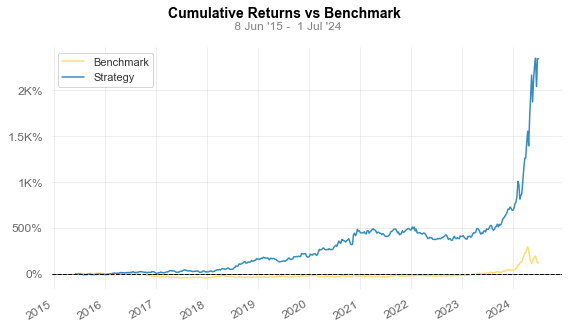

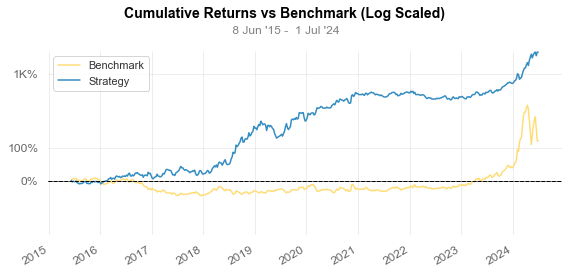

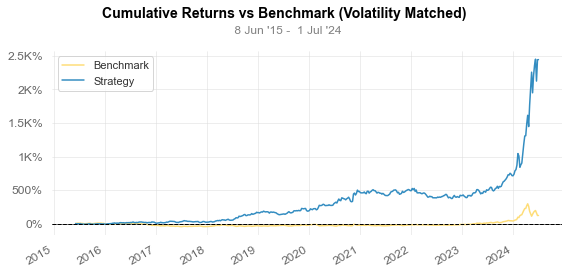

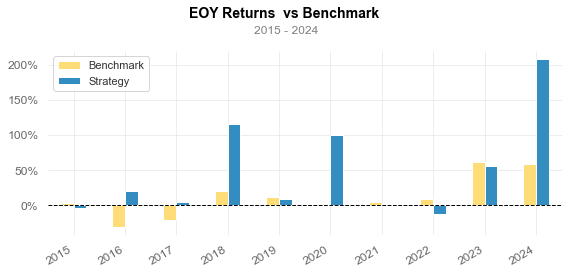

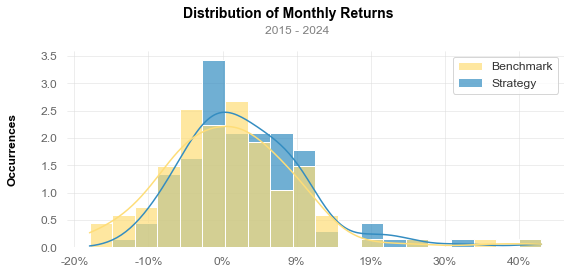

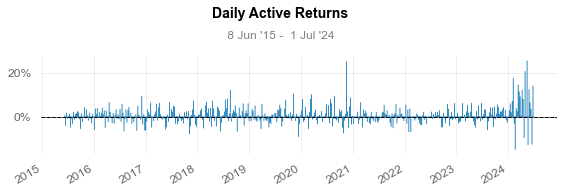

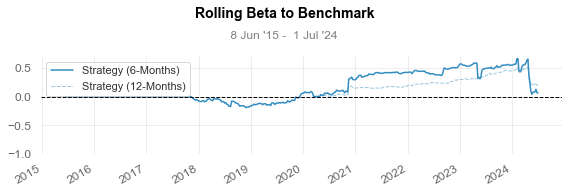

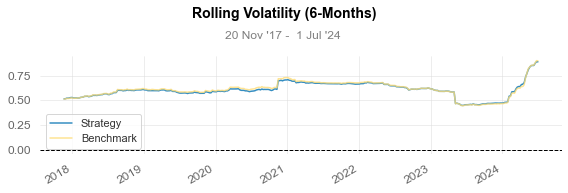

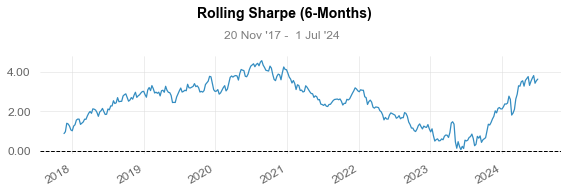

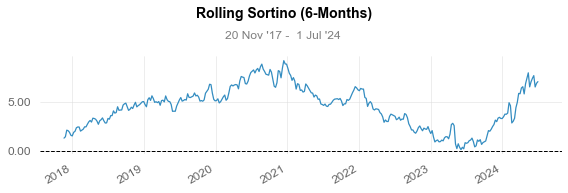

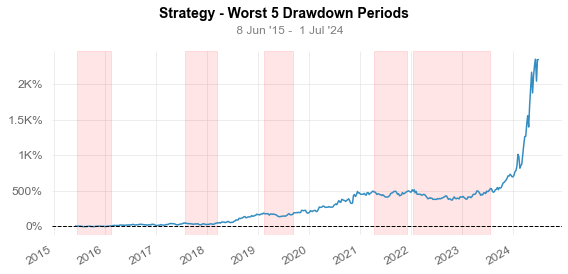

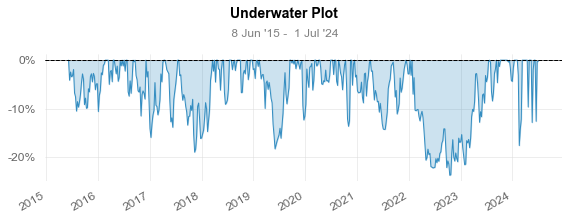

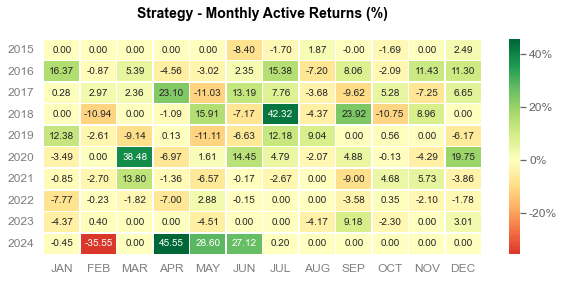

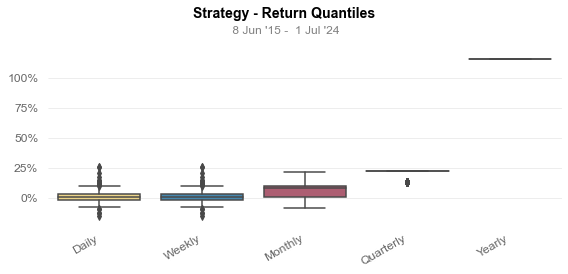

In [32]:
# Generating performance report
qs.reports.full(model,
               benchmark = buy_hold, rf=latest_rf_rate)